In [1]:
import pandas as pd 
import numpy as np
import pickle
from collections import defaultdict
import tensorflow as tf

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def get_origin_path(stat):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})
    return path_link_df

def get_UE_link_cost(stat):
    # return a dataframe of link cost, link flow
    link = stat['data']['network'].copy()
    link['link_flow'] = stat['link_flow']
    # Calculate link cost
    link['link_cost'] = round(link['free_flow_time']*\
                            (1+link['b']*((link['link_flow']/link['capacity'])**4)), 2)
    return link

# Calculate path travel time for each od pair
def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_time = 0
    for l in row:
        sum_time += link_df.at[l, 'link_cost']
    return round(sum_time, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

# Check UE of origin dataset 
def mean_path_cost(filename):
    stat = read_file(filename)
    path_link_df = get_origin_path(stat)
    UE_link = get_UE_link_cost(stat)

    path_link_df['path1_cost'] = path_link_df['path1'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path2_cost'] = path_link_df['path2'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path3_cost'] = path_link_df['path3'].apply(lambda x: calculate_path_cost(x, UE_link))

    flows = stat['path_flow']
    path_link_df['flow1'] = [f[0] if len(f)>0 else 0 for f in flows]
    path_link_df['flow2'] = [f[1] if len(f)>1 else 0 for f in flows]
    path_link_df['flow3'] = [f[2] if len(f)>2 else 0 for f in flows]

    mean_path_cost = (np.nanmean(path_link_df['path1_cost']) + np.nanmean(path_link_df['path2_cost']) + np.nanmean(path_link_df['path3_cost']))/3
    return UE_link, path_link_df, mean_path_cost

def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['link_flow']/output['capacity'])**4)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['flow1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['flow2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['flow3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay
# path_link_df.head()

In [35]:
from tqdm import tqdm

sum_avg, cost = [], []
size = 1500
for i in tqdm(range(size)):
    file_name = f"../Solution/EMA/Output2/5by5_Data{i}"
    UE_link, df, mean_cost = mean_path_cost(file_name)
    delay = calculate_delay(df, UE_link)
    sum_avg.append(delay)
    cost.append(mean_cost)

delay = np.mean(sum_avg)
mean_cost = np.mean(cost)

print("Mean path cost: ", mean_cost, " hours")
print("Delay: ", delay, " hours = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 1500/1500 [00:49<00:00, 30.28it/s]

Mean path cost:  13.277706800808389  hours
Delay:  0.0029196242108756477  hours =  0.02 %


In [23]:
# Average path cost

for j in range(4):
    sum_avg, cost = [], []
    size = 1000
    for i in tqdm(range(size)):
        file_name = f"../Solution/EMA/Output{j+1}/5by5_Data{i}"
        UE_link, df, mean_cost = mean_path_cost(file_name)
        delay = calculate_delay(df, UE_link)
        sum_avg.append(delay)
        cost.append(mean_cost)

    delay = np.mean(sum_avg)
    mean_cost = np.mean(cost)

    print("Mean path cost: ", mean_cost, " minutes")
    print("Delay: ", delay, " minutes = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 1000/1000 [00:19<00:00, 51.94it/s]


Mean path cost:  19.07080346052123  minutes
Delay:  0.004756556912802233  minutes =  0.02 %


100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]


Mean path cost:  27.37388129290902  minutes
Delay:  0.009307877732595261  minutes =  0.03 %


100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]


Mean path cost:  36.46728436752656  minutes
Delay:  0.008889134036467216  minutes =  0.02 %


100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]

Mean path cost:  98.87650931697874  minutes
Delay:  0.03522099576284346  minutes =  0.04 %


In [8]:
filename = '../Solution/Output3/5by5_Data0'
stat = read_file(filename)
# a = get_UE_link_cost(stat)
UE_link, path_link_df, mean_path_cost = mean_path_cost(filename)
UE_link

,~,link_id,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,;,link_flow,link_cost
0,NaN,0,1,2,25900.200640,6,6,0.15,4,0,0,1,;,2181.0,6.00
1,NaN,1,1,3,23403.473190,4,4,0.15,4,0,0,1,;,11055.0,4.03
2,NaN,2,2,1,25900.200640,6,6,0.15,4,0,0,1,;,2927.0,6.00
3,NaN,3,2,6,4958.180928,5,5,0.15,4,0,0,1,;,4529.0,5.52
4,NaN,4,3,1,23403.473190,4,4,0.15,4,0,0,1,;,9348.0,4.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,NaN,71,23,22,5000.000000,4,4,0.15,4,0,0,1,;,4036.0,4.25
61,NaN,72,23,24,5078.508436,2,2,0.15,4,0,0,1,;,891.0,2.00
62,NaN,73,24,13,5091.256152,4,4,0.15,4,0,0,1,;,3586.0,4.15
63,NaN,74,24,21,4885.357564,3,3,0.15,4,0,0,1,;,15600.0,49.79


In [30]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder,str(f'/5by5_Data{i}')])
            file_list.append(file)
    return file_list

def normalize(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed


stat = read_file('../SiouxFalls/Output1/5by5_Data0')
net = stat["data"]["network"]
cap = net['capacity']
link_flow = stat['link_flow']

FOLDERS = [f'../SiouxFalls/Output{i+1}' for i in range(1)]
DATA_SIZE = 1000
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
demand = []
od_pair = []

for filename in tqdm(files):
    stat = read_file(filename)
    demand_dic = stat["data"]["demand"]
    d = np.array(list(demand_dic.values())).reshape(-1, 1)
    demand.append(normalize(d).flatten().tolist())
    od_pair.append(len(demand_dic.keys()))
demand = [i for j in demand for i in j]
len(link_flow)

100%|██████████| 1000/1000 [00:13<00:00, 72.17it/s]


1000

In [ ]:
import pandas as pd

FOLDERS = [f'../SiouxFalls/Output{i}' for i in list([1,5,2,3])]
DATA_SIZE = 1000

Link_flow = []
for folder in FOLDERS:
    link_flow = []
    for i in range(DATA_SIZE):
        file = ''.join([folder,str(f'/5by5_Data{i}')])
        stat = read_file(file)
        link_flow.append(stat['link_flow'])
    Link_flow.append(link_flow)

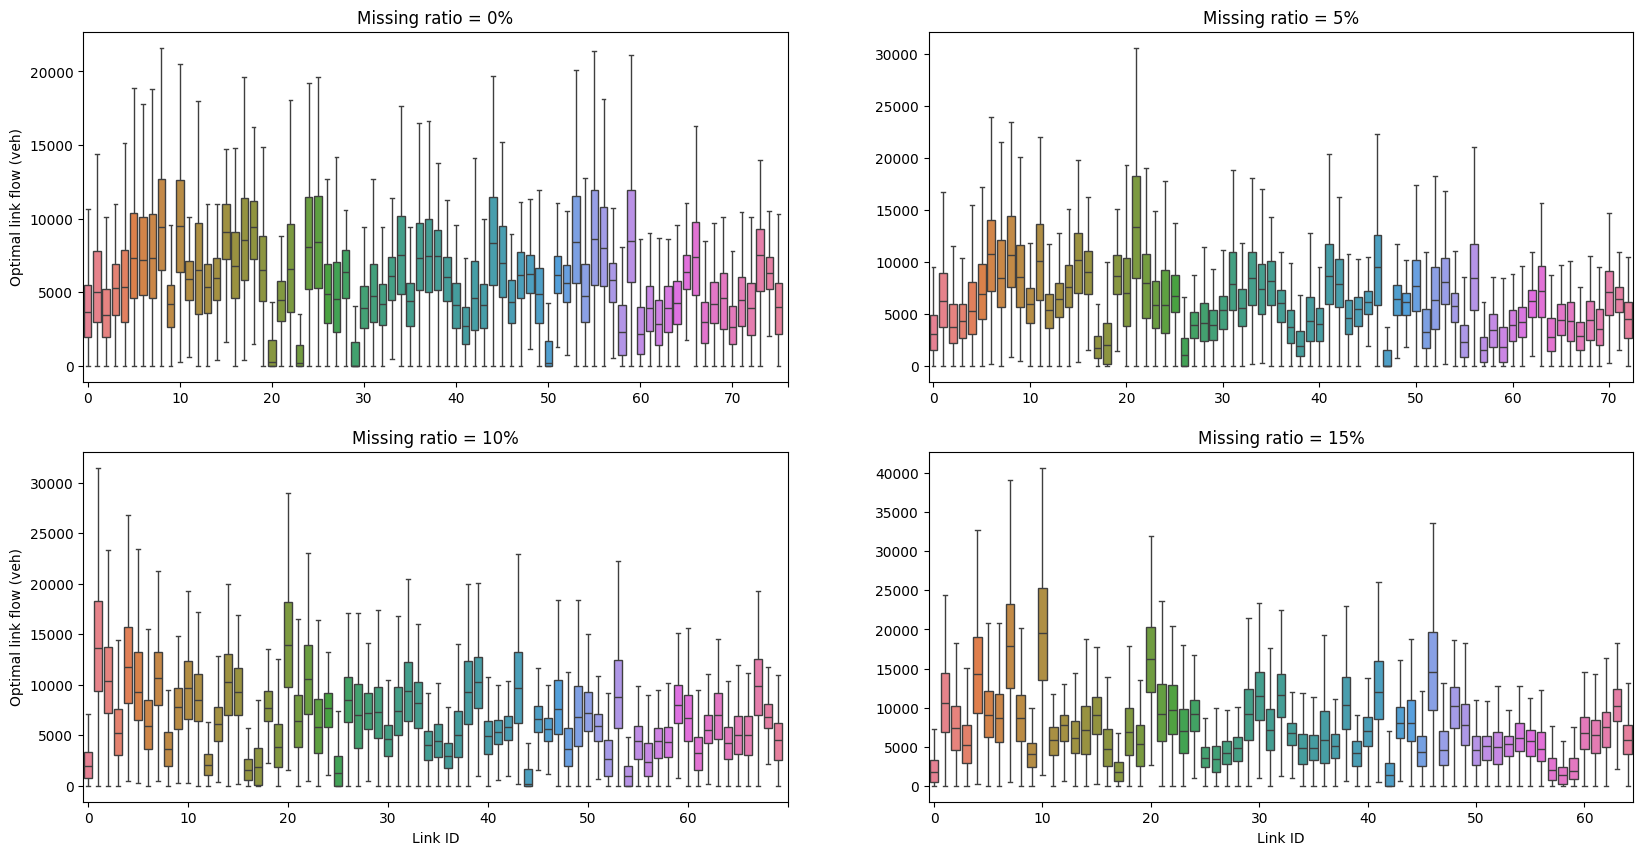

In [50]:
output1 = pd.DataFrame(Link_flow[0]) # full network
output2 = pd.DataFrame(Link_flow[1]) # remove 5%
output3 = pd.DataFrame(Link_flow[2]) # remove 10%
output4 = pd.DataFrame(Link_flow[3]) # remove 15%

plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
sns.boxplot(data=output1, showfliers=False)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 76])
plt.title('Missing ratio = 0%')
plt.ylabel('Optimal link flow (veh)')

plt.subplot(2,2,2)
sns.boxplot(data=output2, showfliers=False)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70])
plt.title('Missing ratio = 5%')

plt.subplot(2,2,3)
sns.boxplot(data=output3, showfliers=False)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70])
plt.title('Missing ratio = 10%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.subplot(2,2,4)
sns.boxplot(data=output4, showfliers=False)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60])
plt.title('Missing ratio = 15%')
plt.xlabel('Link ID')

plt.show()

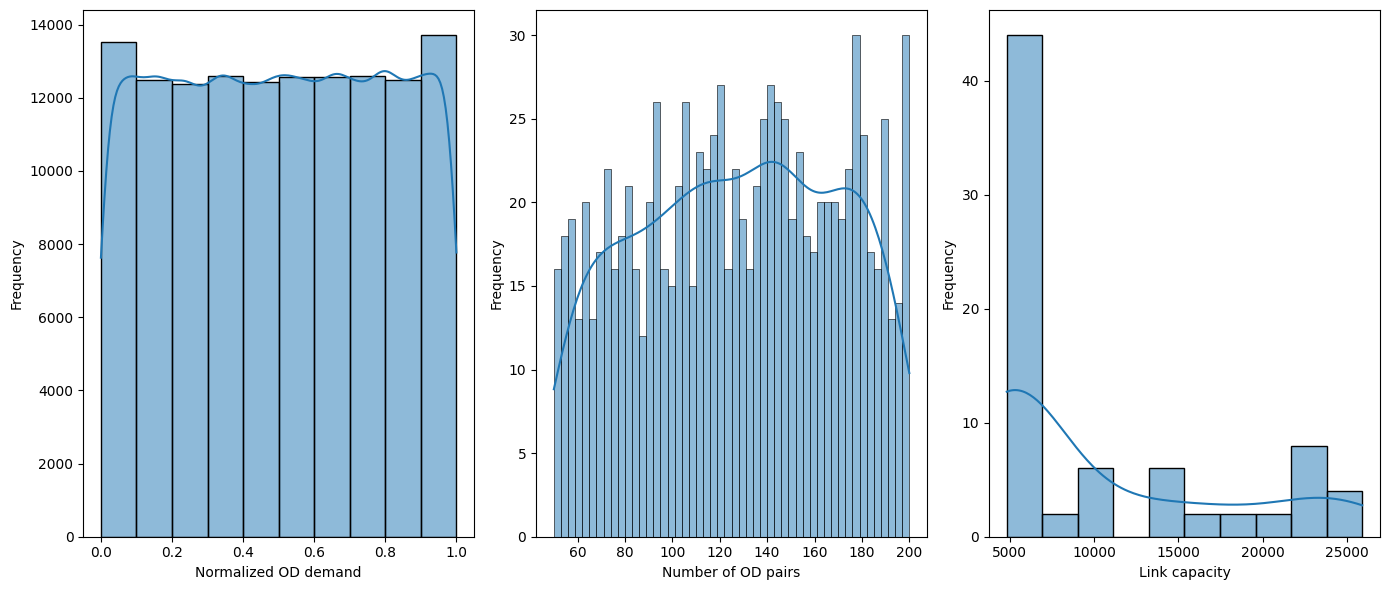

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1,3, 1)
sns.histplot(demand, bins=10, kde=True)
# plt.ylim(100, 400)
plt.xlabel('Normalized OD demand')
plt.ylabel('Frequency')

plt.subplot(1,3, 2)
sns.histplot(od_pair, bins=50, kde=True)
plt.xlabel('Number of OD pairs')
plt.ylabel('Frequency')

plt.subplot(1,3, 3)
sns.histplot(cap, bins=10, kde=True)
plt.xlabel('Link capacity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()